# Round-off errors

When you use `x = 1/49` to compute the reciprocal of 49, you get the fraction 1/49. But if you print `x`, you might be surprised to see

```julia
julia> x = 1/49
0.02040816326530612
```

and then go on to compute `x * 49` and get

```julia
julia> x * 49
0.9999999999999999
```

and not 1.0. What is going on?

The problem is that floating-point numbers are represented with a fixed number of bits, and there are many numbers that cannot be represented exactly with a fixed number of bits. When you write `1/49`, Julia converts the integer 1 to the floating-point representation with 64 bits, and the integer 49 to the floating-point representation with 64 bits, and then divides the two floating-point numbers. The result is very close to 1/49, but not exact.

When you multiply `x` by 49, you get a number that is very close to 1, but not exact, so when you print it, you get `0.9999999999999999`.

What is error of precision? It is the difference between the result you get from a floating-point operation and the result you would get if you could compute the operation with real numbers.

In this example, the error of precision is about `1e-16`, which is the difference between 1 and the floating-point representation of 1.0.


In [1]:
x = 1/49

0.02040816326530612

In [2]:
x * 49

0.9999999999999999

In [3]:
1 - x * 49

1.1102230246251565e-16

In [4]:
function accumulated_error(x)
    y = similar(x) # allocate an array of the same size as x
    y[1] = x[1] # copy the first element
    for i in 2:length(x)
        y[i] = y[i-1] + x[i] # cumulative summation
    end

    return y
end

accumulated_error (generic function with 1 method)

This Julia code utilizes PyPlot for visualization and defines a function `plot_error_analysis()` to analyze the accumulated error in summing 10^7 random single precision values. Here's a step-by-step explanation:

1. **Data Generation**: Generates an array `x` containing 10^7 single precision (Float32) random values uniformly distributed between 0 and 1.

2. **Accumulated Error Calculation**:

   - `@time y = accumulated_error(x)`: Measures the time and computes the accumulated error using a function called `accumulated_error()` (not shown here).

   - `y_exact = accumulated_error(Float64.(x))`: Converts `x` to double precision (Float64) to obtain a more accurate comparison for the accumulated error.

   - `err = abs.(y .- y_exact ./ abs.(y_exact))`: Computes the relative error between the single and double precision accumulations.

3. **Plotting**:

   - Defines `n` to plot every 10th point in the `err` array.

   - `loglog(n, err[n])`: Plots the log-log of the error against the number of summands.

   - Adds axis labels (`ylabel`, `xlabel`) and a title (`title`) for clarity in the plot.

4. **Comparison Line**:

   - `loglog([1, length(err)], sqrt.([1, length(err)]) * 1e-7, "k--")`: Plots a line proportional to √n for comparison.

5. **Text Annotation**:

   - `text(1e3, 1e-5, L"\sim \sqrt{n}", fontsize=16)`: Adds a text annotation displaying the square root relationship at a specified position on the plot.

6. **Execution**:
   - `plot_error_analysis()`: Calls the function to execute the code and display the plot.

This code aims to visualize and analyze the error that arises from summing a large number of single precision random values compared to their double precision counterparts.


  0.097096 seconds (6 allocations: 114.441 MiB, 65.10% gc time)


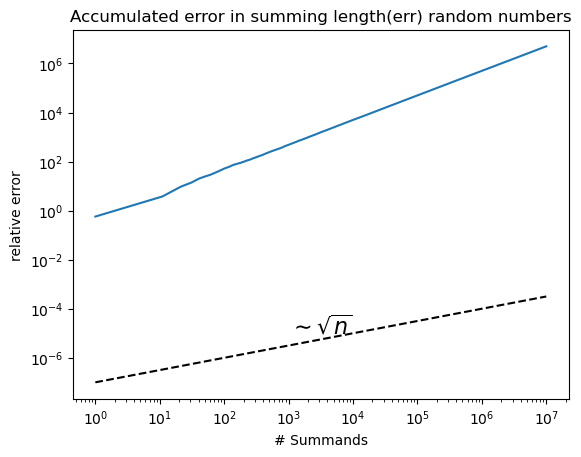

PyObject Text(0.5, 1.0, 'Accumulated error in summing length(err) random numbers')

In [5]:
using PyPlot

function plot_error_analysis()
    x = rand(Float32, 10^7) # 10^7 single precision values uniformly distributed in [0,1]
    @time y = accumulated_error(x)
    y_exact = accumulated_error(Float64.(x)) # convert x to double precision
    err = abs.(y .- y_exact ./ abs.(y_exact)) # relative error

    n = 1:10:length(err) # plot every 10th point
    loglog(n, err[n]) # log-log plot of the error
    ylabel("relative error")
    xlabel("# Summands")

    # plot a √n line for comparison
    loglog([1, length(err)], sqrt.([1, length(err)]) * 1e-7, "k--")
    text(1e3, 1e-5, L"\sim \sqrt{n}", fontsize=16)
    title("Accumulated error in summing $length(err) random numbers")
end

plot_error_analysis()

In [6]:
using BenchmarkTools

function sum_accumulated_error(x)
    y = accumulated_error(x)
    return y[end]
end

x = rand(Float32, 10^7)

@btime sum_accumulated_error($x)

  22.086 ms (6 allocations: 114.44 MiB)


5.0004465f6

In [7]:
using Test

@test sum_accumulated_error(x) ≈ sum(x)

Test Passed